In [1]:
from utils import *

sda = spatialDA()
sda.check_torch_gpu()

octave = sda.mrst_startup()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520

Welcome to the MATLAB Reservoir Simulation Toolbox (MRST)!
You are using the release version 2023a. To download other versions of MRST
and view examples and relevant publications, please visit www.mrst.no

Useful commands for getting started:
 - List all introductory examples:   mrstExamples()
 - List all modules:                 mrstPath('list')
 - Load modules using GUI:           mrstModule('gui')
 - Explore all available data sets:  mrstDatasetGUI()
 - List examples of a module:        mrstExamples('ad-blackoil')
 - Explore modules and publications: mrstExploreModules()
 - Show all examples in all modules: mrstExamples('all')
 - Show settings for MRST:           mrstSettings()
 

Perm All shape: (101, 51, 51)
True Perm: (51, 51) | Perm Ensemble: (100, 51, 51)


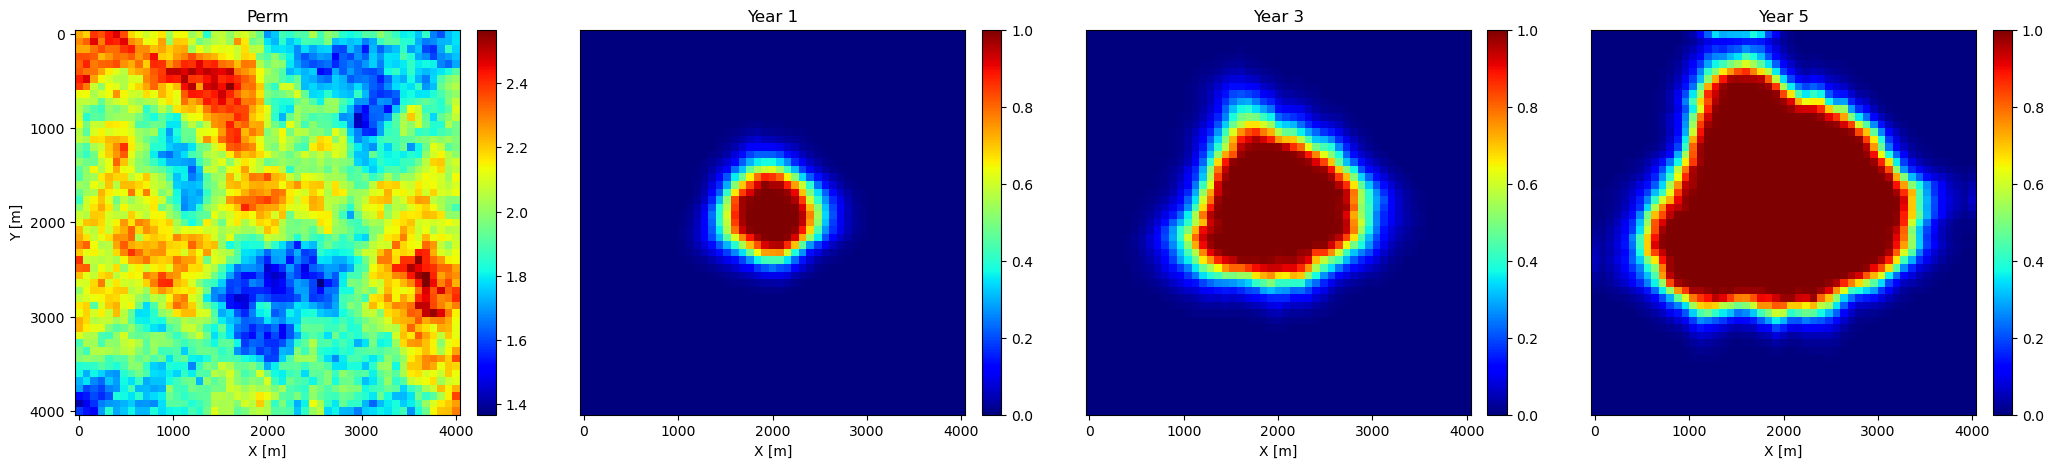

In [2]:
perm_all = sda.load_perm_all()

# sanity check
perm_true, perm_ens = sda.load_perm_true_ens()
sat_true = np.load('sat_true.npy')
sda.plot_perm_sat(perm_true, sat_true)

In [21]:
saturation = {}
for i in range(3):
    saturation[i] = octave.feval('simulations_octave/sim', i)

Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 Years
Solving timestep 7/8: 3 Years -> 4 Years
Solving timestep 8/8: 4 Years -> 5 Years
*** Simulation complete. Solved 8 control steps in 23 Seconds, 338 Milliseconds ***
ans = Simluation 0 DONE!

Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 

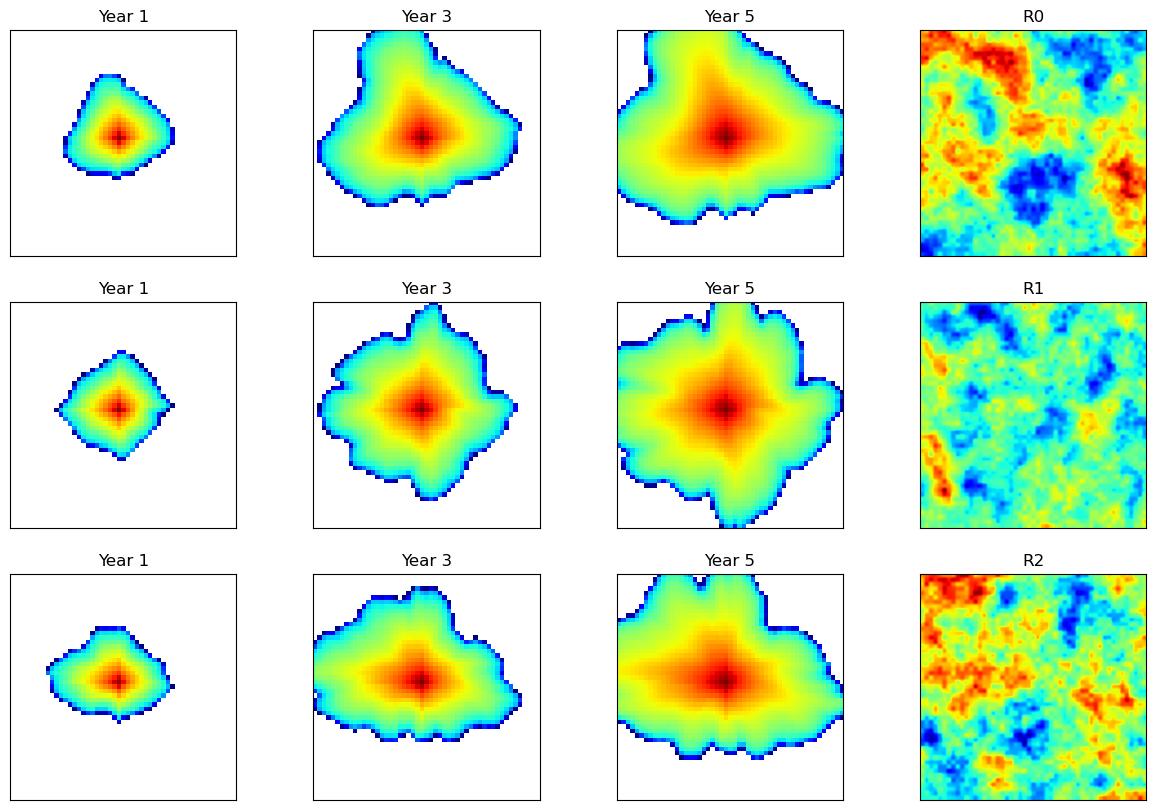

In [23]:
n_realizations, n_timesteps = 3, 3
timesteps = [1, 3, 5]

fig, axs = plt.subplots(n_realizations, n_timesteps+1, figsize=(15,10))
for i in range(n_realizations):
    for j in range(n_timesteps):
        sat = saturation[i][j].reshape(51,51)
        sat_masked = np.ma.masked_where(sat==0, sat)
        axs[i,j].imshow(sat_masked, 'jet')
        axs[i,j].set(xticks=[], yticks=[], title='Year {}'.format(timesteps[j]))
    axs[i,n_timesteps].imshow(perm_all[i], cmap='jet', interpolation='hanning')
    axs[i,n_timesteps].set(xticks=[], yticks=[], title='R{}'.format(i))
plt.show()

***
# ESMDA-GEO

In [ ]:
def exponential(p, x):
    return p[0] * np.exp(x * p[1])

def forward_model(m_ensemble, x):
    d_pred = np.zeros([m_ensemble.shape[0], x.shape[0]])
    for j in range(m_ensemble.shape[0]):
        d_pred[j,:] = exponential(m_ensemble[j,:], x)
    return d_pred

a = 10
b = -0.0020

# Observations
x = np.arange(500) #timesteps
obs = exponential((a,b), x) + np.random.normal(0, 1, x.shape[0])
cov_obs = np.diag([1]*obs.shape[0])

# Ensemble of parameters
n_ensemble = 100
ma = np.random.uniform(2, 20, size=n_ensemble)
mb = np.random.uniform(-0.005, 0, size=n_ensemble)
m_ensemble = np.stack((ma,mb), axis=1)
m_bounds = np.array([[0,50],[-1,1]])

n_assimilations = 3

cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1 / np.array(cov_obs_inflation_factors))

cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]

cov_mm_inflation_factors = [1.2] * n_assimilations

solver = ESMDA(obs, m_ensemble, cov_obs, forward_model, 
               forward_model_args        = (x,),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               m_bounds                  = m_bounds,
               save_ensembles_history    = True)
solver.solve()

#approxtimate parameters
a_approx, b_approx = np.average(solver.m_prior, axis=0)
a_std, b_std = np.sqrt(np.diagonal(solver.cov_mm))

print('a={:.5f} +/- {:.5f}'.format(a_approx, a_std))
print('b={:.5f} +/- {:.5f}'.format(b_approx, b_std))

d = {}
for i in range(100):
    d[i] = exponential([m_ensemble[i,0], m_ensemble[i,1]], x)
    
plt.plot(x, obs, label='$d_{obs}$')
for i in range(100):
    plt.plot(x, d[i], alpha=0.3, c='cyan')
plt.plot(x, exponential([a,b], x), c='k', linewidth=3, linestyle='-', label='true')
plt.plot(x, exponential([a_approx,b_approx], x), c='r', linewidth=3, linestyle='--', label='posterior')
plt.legend(); plt.grid('on')
plt.show()

***
# END